### Important Note
This notebook is designed to be run on [Kaggle](https://www.kaggle.com/) due to its integration with the "Skin Cancer ISIC Images" dataset. 
Please ensure you have access to the dataset by either:

- Running this notebook directly on Kaggle, where the dataset is available.
- Downloading the dataset manually from Kaggle and setting up the file paths if running locally.


In [103]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [104]:
# Import necessary libraries
import numpy as np
import pandas as pd
from skimage import exposure
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import cv2
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)       

## Load Data

In [105]:
# Data Loading and Initial EDA
def load_data(data_dir):
    """
    Load images and labels from directory
    Args:
        data_dir: Path to data directory
    Returns:
        images: numpy array of images
        labels: numpy array of labels
        class_names: list of class names
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(class_idx)
    one_hot_labels = to_categorical(labels)

    return np.array(images), np.array(one_hot_labels), class_names


## EDA

In [106]:
def perform_eda(images, labels, class_names):
    """
    Perform Exploratory Data Analysis specific to skin cancer dataset
    Args:
        images: numpy array of images
        labels: numpy array of labels
        class_names: list of class names
    """
    print("=== Dataset Analysis ===")
    
    # 1. Basic Dataset Statistics
    print(f"\nTotal number of images: {len(images)}")
    print(f"Image dimensions: {images[0].shape}")
    print(f"Number of classes: {len(class_names)}")
    
    # 2. Class Distribution
    class_counts = np.sum(labels, axis=0)  # Sum each column for one-hot labels
    class_distribution = {}
    print("\nClass Distribution:")
    for i, count in enumerate(class_counts):
        percentage = (count / len(labels)) * 100
        print(f"{class_names[i]}: {int(count)} images ({percentage:.2f}%)")
        class_distribution[class_names[i]] = int(count)
    
    
    # 3. Visualize Class Distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
    plt.title('Distribution of Classes')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()
    
    # 4. Image Quality Analysis
    print("\nAnalyzing Image Quality...")
    brightness_values = []
    contrast_values = []
    
    for img in tqdm(images):
        # Calculate brightness
        brightness = np.mean(img)
        brightness_values.append(brightness)
        
        # Calculate contrast
        contrast = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        contrast_values.append(contrast)
    
    # Plot quality metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(brightness_values, ax=ax1)
    ax1.set_title('Brightness Distribution')
    ax1.set_xlabel('Mean Brightness')
    
    sns.histplot(contrast_values, ax=ax2)
    ax2.set_title('Contrast Distribution')
    ax2.set_xlabel('Contrast (Standard Deviation)')
    
    plt.tight_layout()
    plt.show()
    
    return class_distribution, brightness_values, contrast_values

def enhance_image_quality(image):
    """
    Enhance image quality using CLAHE
    Args:
        image: input image
    Returns:
        enhanced image
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[...,0] = clahe.apply(lab[...,0])
    
    # Convert back to RGB
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    return enhanced

def handle_class_imbalance(images, labels, class_distribution):
    """
    Handle class imbalance by upsampling minority class to match majority class
    Args:
        images: numpy array of images
        labels: one-hot encoded labels
        class_distribution: dictionary of class distributions
    Returns:
        balanced images and labels
    """
    # Get class counts from one-hot labels
    class_counts = np.sum(labels, axis=0)
    majority_size = int(max(class_counts))
    
    # Get indices for each class
    class_indices = [np.where(labels[:, i] == 1)[0] for i in range(len(class_counts))]
    
    balanced_images = []
    balanced_labels = []
    
    for i, indices in enumerate(class_indices):
        current_size = len(indices)
        if current_size < majority_size:
            # Oversample minority class
            n_samples_needed = majority_size - current_size
            resampled_indices = np.random.choice(indices, n_samples_needed, replace=True)
            all_indices = np.concatenate([indices, resampled_indices])
        else:
            all_indices = indices
            
        balanced_images.extend(images[all_indices])
        balanced_labels.extend(labels[all_indices])
    
    balanced_images = np.array(balanced_images)
    balanced_labels = np.array(balanced_labels)
    
    print("\nAfter balancing:")
    print(f"Total samples: {len(balanced_images)}")
    print(f"Class distribution: {np.sum(balanced_labels, axis=0)}")
    
    return balanced_images, balanced_labels

def visualize_preprocessing(image):
    """
    Visualize preprocessing steps
    Args:
        image: input image
    """
    # Original
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    
    # Enhanced
    enhanced = enhance_image_quality(image)
    plt.subplot(132)
    plt.imshow(enhanced)
    plt.title('Enhanced')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Preprocessing
Resize & Normalize

In [107]:
def preprocess_images(images, target_size=(28, 28)):
    """
    Preprocess images for model input
    Args:
        images: numpy array of images
        target_size: tuple of target image dimensions
    Returns:
        preprocessed_images: numpy array of preprocessed images
    """
    preprocessed_images = []
    for img in tqdm(images):
        # Resize image
        img_resized = cv2.resize(img, target_size)
        
        # Normalize pixel values
        img_normalized = img_resized / 255.0
        
        preprocessed_images.append(img_normalized)
    
    return np.array(preprocessed_images)

## Data Augmentation


In [108]:
def create_data_generators(train_images, train_labels, val_images, val_labels, 
                         batch_size=128):
    """
    Create data generators for training and validation
    Args:
        train_images: numpy array of training images
        train_labels: numpy array of training labels
        val_images: numpy array of validation images
        val_labels: numpy array of validation labels
        batch_size: batch size for training
    Returns:
        train_generator: training data generator
        val_generator: validation data generator
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )
     
    # Only normalization for validation
    val_datagen = ImageDataGenerator()
    
    # Create generators
    train_generator = train_datagen.flow(
        train_images, train_labels,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_generator = val_datagen.flow(
        val_images, val_labels,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_generator, val_generator


## Create Paper's Model

In [109]:
def create_model(input_shape, num_classes):
    """
    Create CNN model based on the paper's architecture
    Args:
        input_shape: tuple of input image shape
        num_classes: number of classes
    Returns:
        model: compiled keras model
    """
    # Use Input layer as recommended
    inputs = tf.keras.Input(shape=input_shape)
    
    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2, 2)(x)
    
    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    
    # Convolutional layer with padding='same' 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Fourth convolutional block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    
    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Train Model

In [110]:
def train_model(model, train_generator, val_generator, epochs=50):
    """
    Train the model with callbacks
    Args:
        model: compiled keras model
        train_generator: training data generator
        val_generator: validation data generator
        epochs: number of epochs to train
    Returns:
        history: training history
    """
    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    return history


In [111]:
def print_simple_summary(model):
    """
    Print a simple model summary using Keras built-in method
    Args:
        model: keras model
    """
    print("\nModel Architecture:")
    model.summary()
    
    # Print layer types without parameter counting
    print("\nLayer Types:")
    for idx, layer in enumerate(model.layers):
        print(f"Layer {idx}: {layer.__class__.__name__}")

In [112]:
def visualize_predictions(model, test_images, test_labels, class_names, num_examples=5):
    """
    Visualize model predictions on test images
    
    Args:
        model: trained keras model
        test_images: numpy array of test images
        test_labels: numpy array of test labels (binary or one-hot)
        class_names: list of class names
        num_examples: number of examples to visualize
    """
    # Get predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1) if predictions.shape[1] > 1 else (predictions > 0.5).astype(int)
    
    # Convert labels to class indices if they're one-hot encoded
    true_classes = np.argmax(test_labels, axis=1) if len(test_labels.shape) > 1 else test_labels
    
    # Select random examples
    indices = np.random.choice(len(test_images), num_examples, replace=False)
    
    # Create figure
    plt.figure(figsize=(15, 3))
    
    # Plot each example
    for i, idx in enumerate(indices):
        plt.subplot(1, num_examples, i + 1)
        
        # Display image
        img = test_images[idx]
        if len(img.shape) == 3:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap='gray')
            
        # Get true and predicted labels
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        
        # Set title color based on prediction correctness
        title_color = 'green' if true_label == pred_label else 'red'
        
        # Add title with true and predicted labels
        plt.title(f'True: {true_label}\nPred: {pred_label}', 
                 color=title_color,
                 fontsize=10,
                 pad=5)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy for visualized examples
    correct = sum(true_classes[indices] == predicted_classes[indices])
    print(f"\nAccuracy on visualized examples: {correct}/{num_examples} ({100*correct/num_examples:.1f}%)")
    
    # Add confidence scores for predictions
    print("\nDetailed predictions for visualized examples:")
    for idx in indices:
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        
        if predictions.shape[1] > 1:  # multi-class
            confidence = predictions[idx][predicted_classes[idx]] * 100
        else:  # binary
            confidence = (predictions[idx][0] if predicted_classes[idx] == 1 else (1 - predictions[idx][0])) * 100
            
        status = "✓" if true_label == pred_label else "✗"
        print(f"{status} True: {true_label:15} Predicted: {pred_label:15} Confidence: {confidence:.1f}%")

## Evaluate Model

In [113]:
def evaluate_model(model, test_images, test_labels, class_names):
    """
    Evaluate model performance with support for both binary and one-hot encoded labels
    
    Args:
        model: trained keras model
        test_images: numpy array of test images
        test_labels: numpy array of test labels (binary or one-hot)
        class_names: list of class names
    """
    # Get predictions
    predictions = model.predict(test_images)
    
    # Convert predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1) if predictions.shape[1] > 1 else (predictions > 0.5).astype(int)
    
    # Convert one-hot test labels to class indices if needed
    true_classes = np.argmax(test_labels, axis=1) if len(test_labels.shape) > 1 else test_labels
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot ROC curve for binary classification
    if len(class_names) == 2:
        # Handle binary case
        if len(test_labels.shape) > 1:  # one-hot encoded
            true_binary = test_labels[:, 1]  # assume positive class is index 1
        else:
            true_binary = test_labels
            
        if predictions.shape[1] > 1:  # model outputs probabilities for both classes
            pred_binary = predictions[:, 1]  # use probability of positive class
        else:
            pred_binary = predictions.ravel()
            
        fpr, tpr, _ = roc_curve(true_binary, pred_binary)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    # Add detailed metrics
    print("\nDetailed Metrics:")
    for i, class_name in enumerate(class_names):
        true_binary = (true_classes == i)
        pred_binary = (predicted_classes == i)
        
        tn, fp, fn, tp = confusion_matrix(true_binary, pred_binary).ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClass: {class_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")

# Helper function to convert labels to one-hot encoding if needed
def prepare_labels(labels, num_classes):
    """
    Convert labels to one-hot encoding if they aren't already
    
    Args:
        labels: numpy array of labels
        num_classes: number of classes
    Returns:
        one_hot_labels: one-hot encoded labels
    """
    if len(labels.shape) == 1:
        return tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    return labels



In [114]:
def visualize_model_architecture(model):
    """
    Create and save a visualization of the model architecture
    Args:
        model: keras model
    """
    try:
        from tensorflow.keras.utils import plot_model
        
        # Create visualization
        plot_model(
            model,
            to_file='model_architecture.png',
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB'
        )
        
        # Display using matplotlib
        from IPython.display import Image, display
        display(Image('model_architecture.png'))
        
    except Exception as e:
        print(f"Could not create model visualization: {str(e)}")
        print("Please ensure graphviz is installed:")
        print("!apt-get install graphviz")


In [115]:
def plot_training_history(history):
    """
    Plot training history
    Args:
        history: training history object
    """
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [116]:
# Load data
DATA_DIR = '/kaggle/input/skin-cancer-isic-images/'  # Update with your Kaggle dataset path
images, labels, class_names = load_data(DATA_DIR)

100%|██████████| 1497/1497 [00:02<00:00, 627.23it/s]


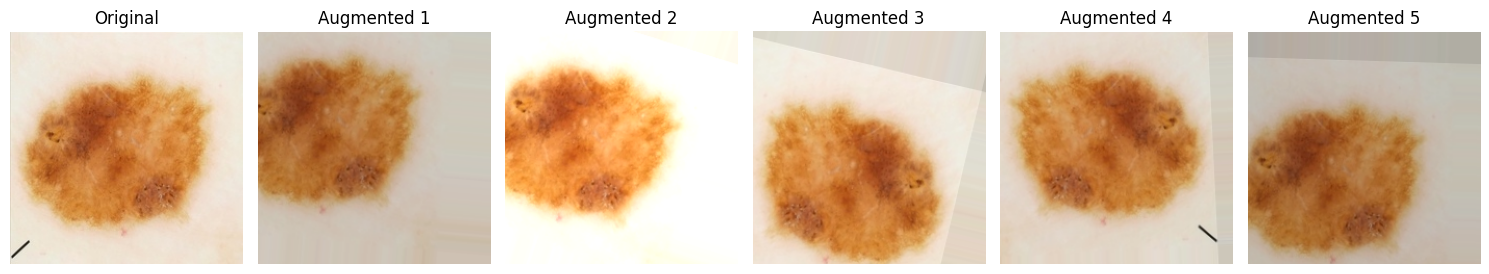

In [117]:
def show_augmentation_examples(image):
    """
    Simpler function to demonstrate augmentation effects
    """
    # Create generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Prepare image
    image = np.expand_dims(image, 0)
    
    # Create figure
    plt.figure(figsize=(15, 3))
    
    # Show original
    plt.subplot(1, 6, 1)
    plt.imshow(image[0].astype(np.uint8))
    plt.title('Original')
    plt.axis('off')
    
    # Generate and show augmented images
    it = datagen.flow(image, batch_size=1)
    for i in range(5):
        batch = it.__next__()
        plt.subplot(1, 6, i + 2)
        plt.imshow(batch[0].astype(np.uint8))
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Try the simpler version
try:
    if 'images' in locals() and len(images) > 0:
        show_augmentation_examples(images[0])
    else:
        print("Please load your images first!")
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [118]:
# Simulating the training process with a small dataset
def demonstrate_epoch_processing():
    """
    Demonstrate how images are processed in one epoch
    """
    # Simulate a tiny dataset of 5 images
    print("Example with 5 images in dataset:")
    print("\nEPOCH 1:")
    for i in range(5):
        print(f"Step {i+1}: Original Image {i+1} → Gets augmented → Model trains on ONLY the augmented version")
    
    print("\nEPOCH 2:")
    for i in range(5):
        print(f"Step {i+1}: Original Image {i+1} → Gets differently augmented → Model trains on ONLY the new augmented version")

# Run the demonstration
demonstrate_epoch_processing()

print("\n=== KEY POINTS ===")
print("1. In each epoch:")
print("   - Each original image is used exactly once")
print("   - It gets randomly augmented")
print("   - Only the augmented version is used for training")
print("   - Original image is NOT used for training")
print("\n2. If you have 1000 images:")
print("   - Each epoch still processes 1000 images (augmented versions)")
print("   - NOT 2000 images (it doesn't use both original and augmented)")
print("\n3. The benefit comes from:")
print("   - Each epoch sees different variations of the same images")
print("   - But the number of images per epoch stays the same")

Example with 5 images in dataset:

EPOCH 1:
Step 1: Original Image 1 → Gets augmented → Model trains on ONLY the augmented version
Step 2: Original Image 2 → Gets augmented → Model trains on ONLY the augmented version
Step 3: Original Image 3 → Gets augmented → Model trains on ONLY the augmented version
Step 4: Original Image 4 → Gets augmented → Model trains on ONLY the augmented version
Step 5: Original Image 5 → Gets augmented → Model trains on ONLY the augmented version

EPOCH 2:
Step 1: Original Image 1 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 2: Original Image 2 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 3: Original Image 3 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 4: Original Image 4 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 5: Original Image 5 → Gets differently augmented → Model trains on ONLY the new augmented vers

## Preprocess & Split Data

=== Dataset Analysis ===

Total number of images: 3297
Image dimensions: (224, 224, 3)
Number of classes: 2

Class Distribution:
benign: 1800 images (54.60%)
malignant: 1497 images (45.40%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


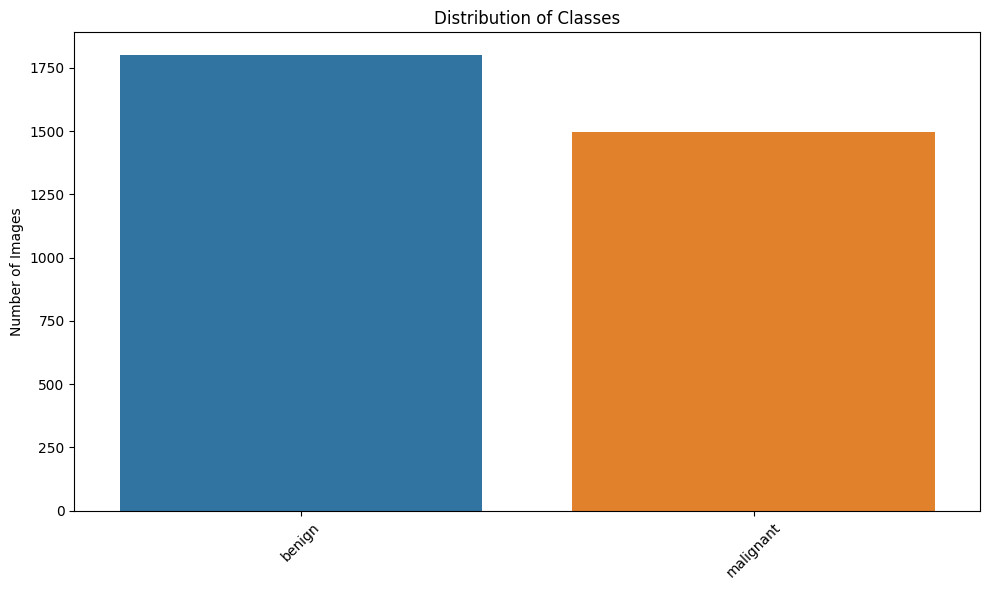


Analyzing Image Quality...


100%|██████████| 3297/3297 [00:00<00:00, 3408.68it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


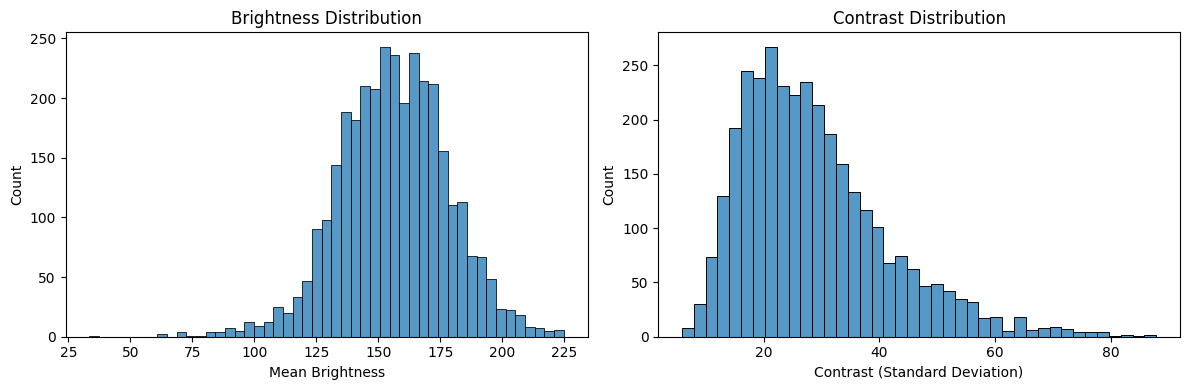


Visualizing preprocessing steps on a sample image...


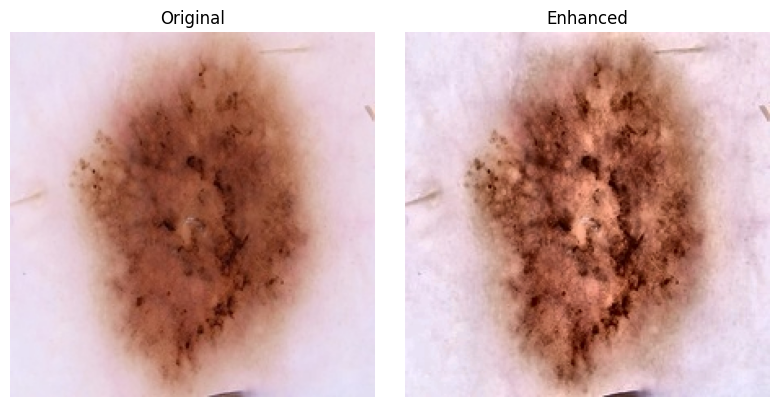

Enhancing images: 100%|██████████| 3297/3297 [00:06<00:00, 536.27it/s]



Handling class imbalance...

After balancing:
Total samples: 3600
Class distribution: [1800. 1800.]


100%|██████████| 3297/3297 [00:00<00:00, 48498.67it/s]


In [119]:
# Perform EDA
class_distribution, brightness_values, contrast_values = perform_eda(images, labels, class_names)

# Show preprocessing example on one image
sample_idx = np.random.randint(len(images))
print("\nVisualizing preprocessing steps on a sample image...")
visualize_preprocessing(images[sample_idx])
enhanced_images = []
for image in tqdm(images, desc="Enhancing images"):
    enhanced = enhance_image_quality(image)
    enhanced_images.append(enhanced)

enhanced_images = np.array(enhanced_images)
    

# Handle class imbalance
print("\nHandling class imbalance...")
balanced_images, balanced_labels = handle_class_imbalance(enhanced_images, labels, class_distribution)

# Preprocess images
preprocessed_images = preprocess_images(images)

# Split data
train_images, temp_images, train_labels, temp_labels = train_test_split(
    preprocessed_images, labels, test_size=0.2, random_state=42, stratify=labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create data generators
train_generator, val_generator = create_data_generators(
    train_images, train_labels, val_images, val_labels
)

## Create Model


Model Architecture:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,162 (1.74 MB)

 Trainable params: 456,162 (1.74 MB)

 Non-trainable params: 0 (0.00 B)


Layer Types:
Layer 0: InputLayer
Layer 1: Conv2D
Layer 2: MaxPooling2D
Layer 3: Conv2D
Layer 4: MaxPooling2D
Layer 5: Conv2D
Layer 6: MaxPooling2D
Layer 7: Conv2D
Layer 8: MaxPooling2D
Layer 9: Flatten
Layer 10: Dense
Layer 11: Dropout
Layer 12: Dense
Layer 13: Dropout
Layer 14: Dense


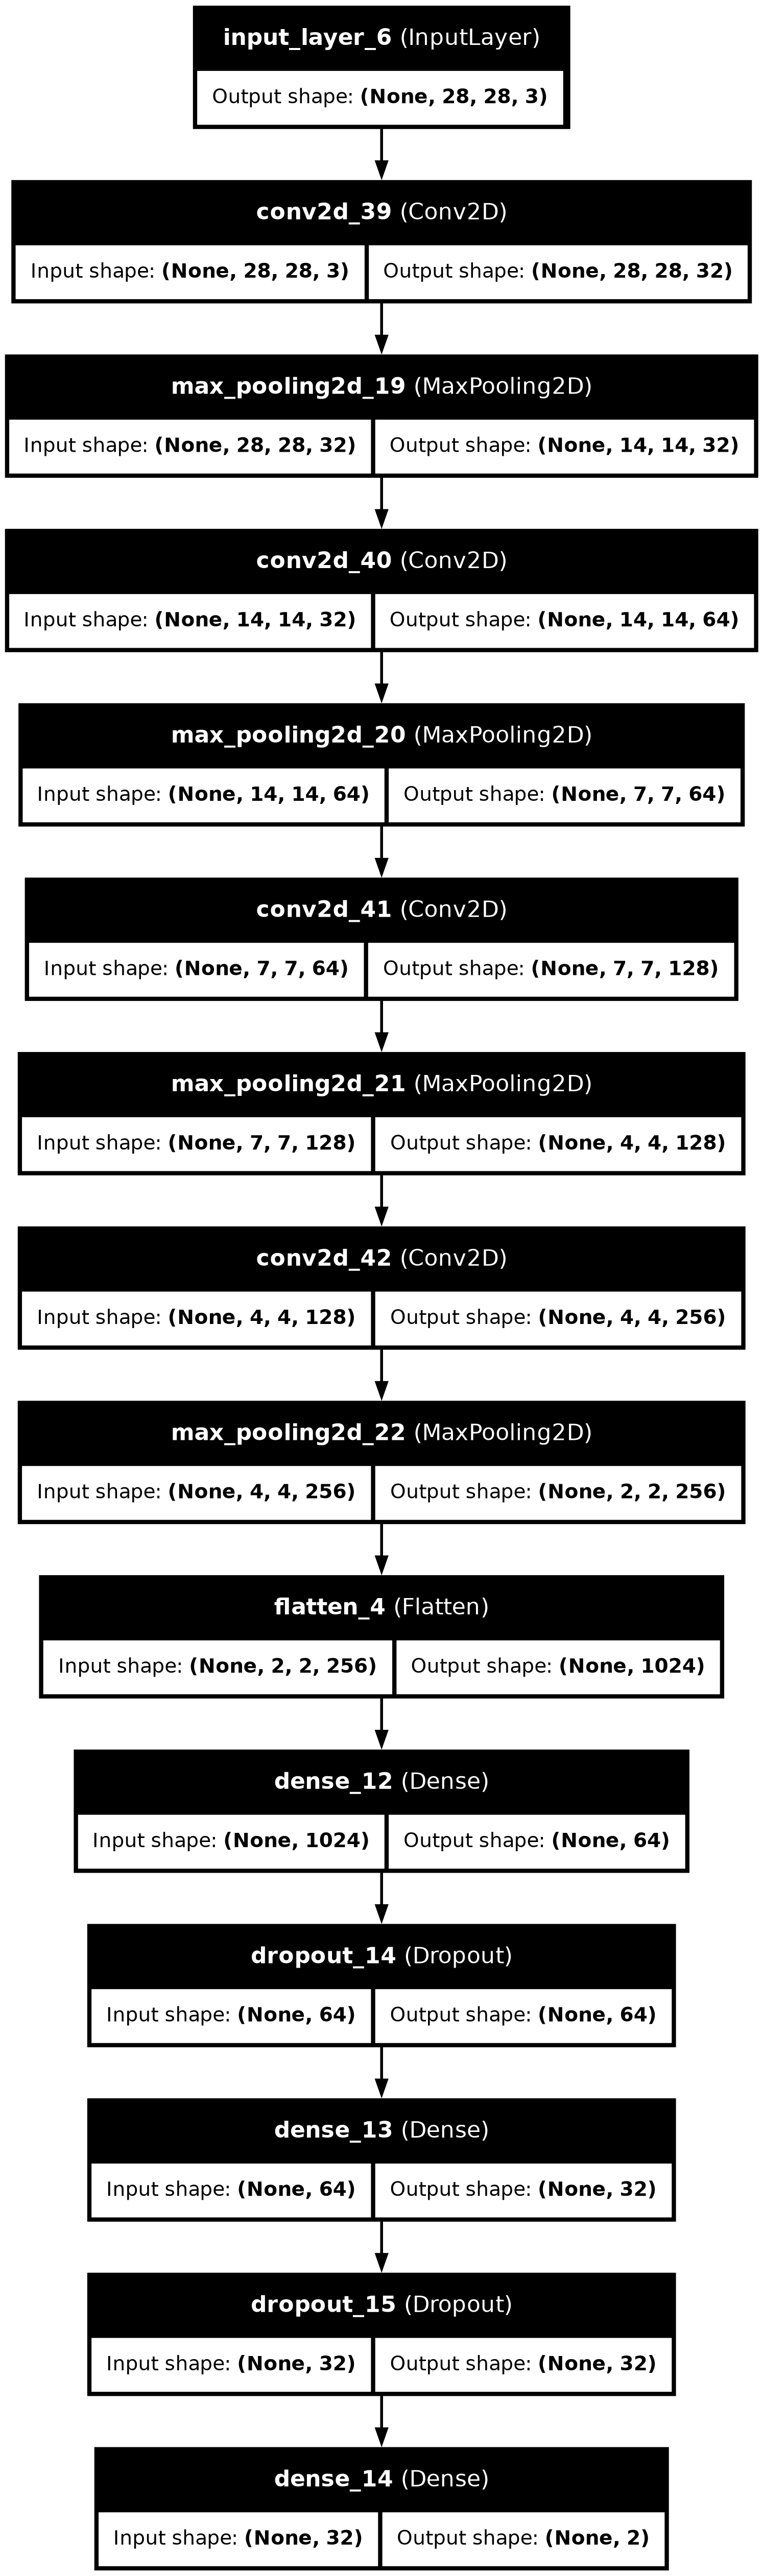

In [120]:
# Create Model
model = create_model(input_shape=(28, 28, 3), num_classes=len(class_names))

# Print summary
print_simple_summary(model)

# Try to visualize architecture
visualize_model_architecture(model)

## Train & Evaluate

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5130 - loss: 0.6929
Epoch 1: val_accuracy improved from -inf to 0.54545, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5134 - loss: 0.6927 - val_accuracy: 0.5455 - val_loss: 0.6590 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5999 - loss: 0.6497
Epoch 2: val_accuracy improved from 0.54545 to 0.70303, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6015 - loss: 0.6491 - val_accuracy: 0.7030 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7069 - loss: 0.6010
Epoch 3: val_accuracy did not improve from 0.70303
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7066 - loss: 0.6009 - val_accuracy: 0.7000 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6889 - loss: 0.5936
Epoch 4: val_accuracy 

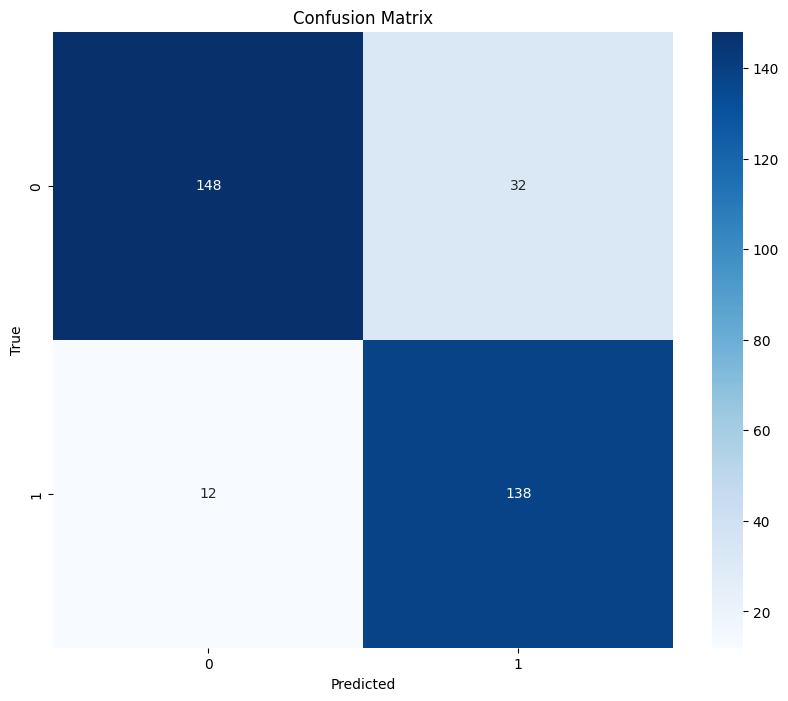

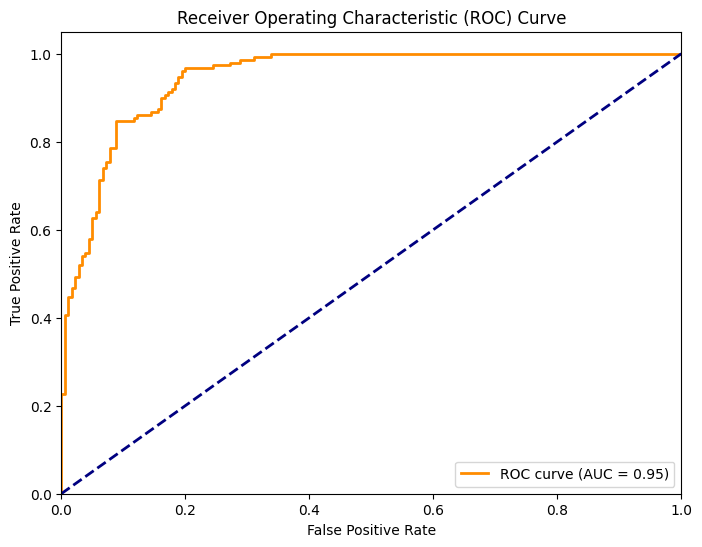


Detailed Metrics:

Class: benign
Accuracy: 0.8667
Precision: 0.9250
Recall: 0.8222
F1-score: 0.8706
True Positives: 148
False Positives: 12
True Negatives: 138
False Negatives: 32

Class: malignant
Accuracy: 0.8667
Precision: 0.8118
Recall: 0.9200
F1-score: 0.8625
True Positives: 138
False Positives: 32
True Negatives: 148
False Negatives: 12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


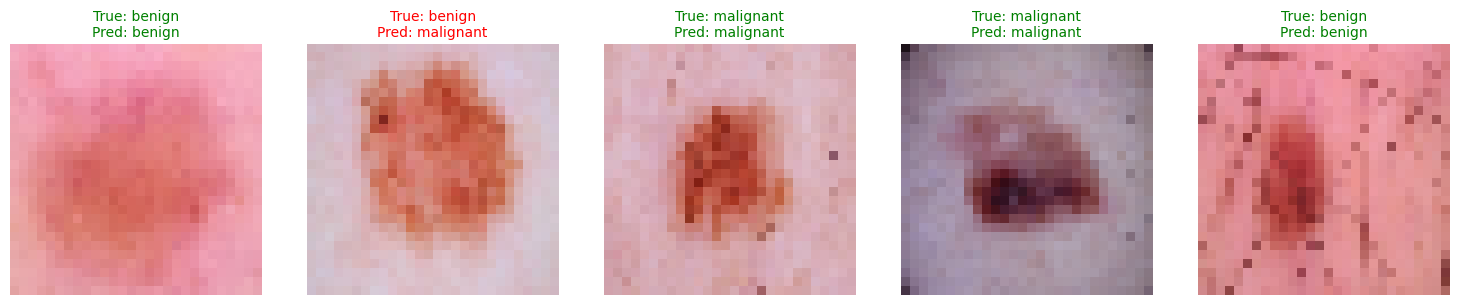


Accuracy on visualized examples: 4/5 (80.0%)

Detailed predictions for visualized examples:
✓ True: benign          Predicted: benign          Confidence: 100.0%
✗ True: benign          Predicted: malignant       Confidence: 98.9%
✓ True: malignant       Predicted: malignant       Confidence: 97.7%
✓ True: malignant       Predicted: malignant       Confidence: 88.6%
✓ True: benign          Predicted: benign          Confidence: 100.0%


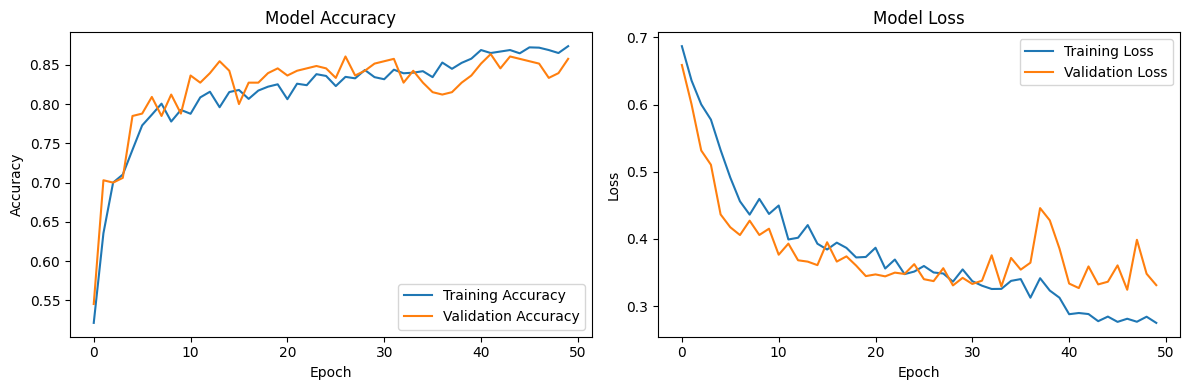

In [121]:
# When preparing your data:
num_classes = len(class_names)
train_labels = prepare_labels(train_labels, num_classes)
val_labels = prepare_labels(val_labels, num_classes)
test_labels = prepare_labels(test_labels, num_classes)

# Train model
history = train_model(model, train_generator, val_generator)

# Print model overview
print("\nModel Overview:")

# Evaluate model
evaluate_model(model, test_images, test_labels, class_names)

# Visualize some predictions
visualize_predictions(model, test_images, test_labels, class_names)

# Plot training history
plot_training_history(history)